In [1]:
### Set CUDA device
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [2]:
import numpy as np
import pandas as pd
import torch
from torch import Tensor, nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import sys
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict
from torchvision.transforms import GaussianBlur
from torchmetrics.functional.classification import dice
from sklearn.covariance import LedoitWolf

## Augmentations
from batchgenerators.transforms.noise_transforms import augment_gaussian_blur


sys.path.append('../')
from data_utils import get_eval_data
from model.unet import get_unet
from utils import  epoch_average, UMapGenerator
from model.mahalanobis_adatper import (
    get_pooling_mahalanobis_detector, 
    get_batchnorm_mahalanobis_detector
)
from model.wrapper import PoolingMahalanobisWrapper, BatchNormMahalanobisWrapper

# from losses import (
#     DiceScoreCalgary, 
#     DiceScoreMMS
# )

nnUNet_raw_data_base is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
RESULTS_FOLDER is not defined and nnU-Net cannot be used for training or inference. If this is not intended behavior, please read documentation/setting_up_paths.md for information on how to set this up.


In [3]:
### Load basic config
cfg = OmegaConf.load('../configs/basic_config_venusberg.yaml')
OmegaConf.update(cfg, 'run.iteration', 0)

In [4]:
### Set dataset, either brain or heart
DATA_KEY = 'heart'
OmegaConf.update(cfg, 'run.data_key', DATA_KEY)


### get model
# available models:
#     - default-8
#     - default-16
#     - monai-8-4-4
#     - monai-16-4-4
#     - monai-16-4-8
#     - monai-32-4-4
#     - monai-64-4-4
#     - swinunetr


unet_name = 'default-8'
postfix = '_no-blurring'
args = unet_name.split('-')
cfg.unet[DATA_KEY].pre = unet_name + postfix
cfg.unet[DATA_KEY].arch = args[0]
cfg.unet[DATA_KEY].n_filters_init = int(args[1])

if args[0] == 'monai':
    cfg.unet[DATA_KEY].depth = int(args[2])
    cfg.unet[DATA_KEY].num_res_units = int(args[3])


unet, state_dict = get_unet(
    cfg,
    update_cfg_with_swivels=False,
    return_state_dict=True)
unet.load_state_dict(state_dict)
_ = unet.cuda()

In [5]:
# Set debug mode for only a small fraction of the datasets. Speeds up this cell by alot
cfg.debug = False

# update config with default values
OmegaConf.update(
    cfg, 
    'eval',
    OmegaConf.load('../configs/eval/unet_config.yaml')
)

# Wether and how you want to subset in case of Brain data. WARNING:
# After subsetting the eval below will not work with surface
# Dice anymore, because volumes are fragmented. 
APPLY_SUBSETTING = True
OmegaConf.update(cfg, 'eval.data.subset.apply', APPLY_SUBSETTING)
subset_params = {
    'n_cases': 256,  # selects at most so many cases
    'fraction': 0.1, # selects from the 10% worst cases w.r.t to a model
}
OmegaConf.update(
    cfg, 
    'eval.data.subset.params', 
    OmegaConf.create(subset_params)
)

if cfg.eval.data.subset.apply:
    subset_dict = OmegaConf.to_container(
        cfg.eval.data.subset.params, 
        resolve=True, 
        throw_on_missing=True
    )
    subset_dict['unet'] = unet
else:
    subset_dict = None

### select the datasets within the domain
# get training data
cfg.eval.data.training = True
# get validation data
cfg.eval.data.validation = False
# get testing data
# Options for Brain are any subset of [1, 2, 3, 4, 5] or 'all' 
# Options for Heart are any subset of ['A', 'B', 'C', 'D'] or 'all'
cfg.eval.data.testing = ['A'] #'all'


data = get_eval_data(
    train_set=cfg.eval.data.training,
    val_set=cfg.eval.data.validation,
    test_sets=cfg.eval.data.testing,    
    cfg=cfg,
    subset_dict=subset_dict
)

print(f'\nAvailable datasets are: {list(data.keys())}')

loading dataset
loading all case properties
loading dataset
loading all case properties

Available datasets are: ['train', 'A']


In [6]:
dataloader = DataLoader(
    data['train'],
    batch_size=32,
    shuffle=False,
    num_workers=4,
    drop_last=False,
)

In [15]:
swivels = [layer[0] for layer in unet.named_modules() if 'bn' in layer[0]]

# swivels=['up3.0.conv_path.0.bn']

mahalanobis_detector = get_pooling_mahalanobis_detector(
    swivels=swivels,
    unet=unet,
    pool='none',
    sigma_algorithm='diagonal',
    fit='raw',
    iid_data=dataloader,
    transform=True,
    dist_fn='mahalanobis',
    device='cuda:0'
)

In [16]:
device = ['cuda:0', 'cpu']
# umap = 'top2diff_diff'
umap = 'diff_grad'
# umap='cross_entropy'
net_out = 'heart'

test_loader = DataLoader(
    data['A'],
    batch_size=32,
    shuffle=False,
    num_workers=4,
    drop_last=False,
)

umap_generator = UMapGenerator(
    method=umap,
    net_out=net_out,
).to(device[0])

# lr_ranges = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0]

lr_ranges = [1e-3, 1e-2, 1e-1, 1e-0, 1e1, 1e2, 1e3, 1e4]
score_list = []

for i in range(len(lr_ranges)-1):
    scores = {
        'pos': {},
        'neg': {}
    }
    lr_start = lr_ranges[i]
    lr_stop  = lr_ranges[i+1]
    value_range = torch.linspace(lr_start, lr_stop, 10)

    for batch in test_loader:
        
        x_in = batch['input'].to(device[0])
        target = batch['target']
        target[target == -1] = 0

        # get the output of the network
        mahalanobis_detector.set_transform(False)
        with torch.no_grad():
            output_model = mahalanobis_detector(x_in).detach().cpu()
            prediction_model = torch.argmax(output_model, dim=1, keepdim=True)
            assert prediction_model.shape == target.shape, f'{prediction_model.shape} != {target.shape}'
            error_model = prediction_model != target

        # get gradient shifted output for each LR in range
        mahalanobis_detector.set_transform(True)
        for i, lr in enumerate(value_range):
            mahalanobis_detector.set_lr(lr)
            output_shifted = mahalanobis_detector(x_in).detach().cpu()
            umap_in = torch.cat([output_model, output_shifted], dim=0)
            umap = umap_generator(
                umap_in,
                batch_size=output_shifted.shape[0]
            ) / lr
            scores['neg'].setdefault(i, []).append(umap[error_model == 1].flatten().detach())
            scores['pos'].setdefault(i, []).append(umap[error_model == 0].flatten().detach())

            
    score_list.append(scores)


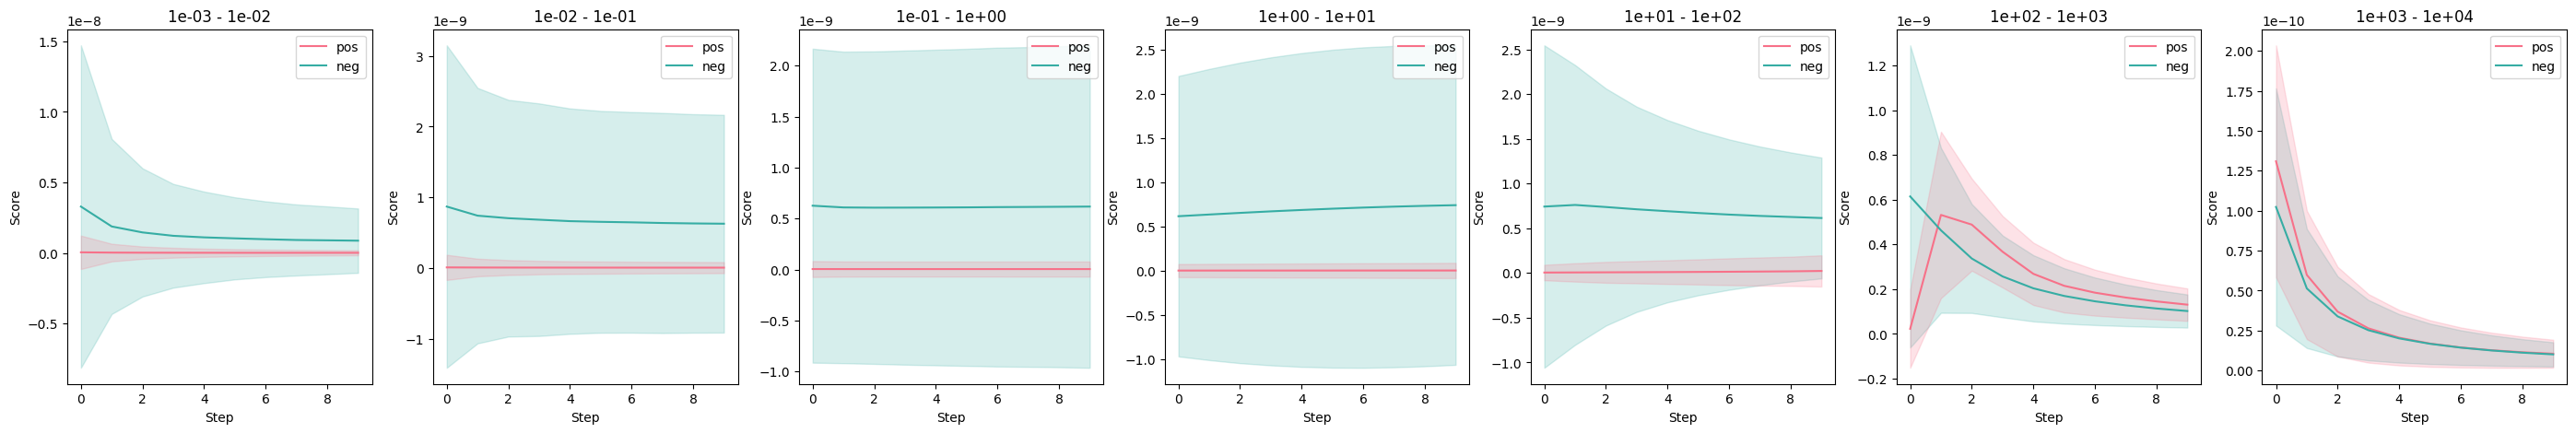

In [17]:
def format_e(n):
    a = '%e' % n
    return a.split('e')[0].rstrip('0').rstrip('.') + 'e' + a.split('e')[1]

n_plots = len(score_list)
fig, axes = plt.subplots(1, n_plots, figsize=(5 * n_plots, 5))


for i, scores in enumerate(score_list):

    scores_aggregated = pd.DataFrame(columns=['lr', 'type', 'score_mean', 'score_std'])

    for key in scores['pos'].keys():
        scores_aggregated = pd.concat([
            scores_aggregated,
            pd.DataFrame({
                'lr': key,
                'type': 'pos',
                'score_mean': torch.cat(scores['pos'][key]).mean().item(),
                'score_std':  torch.cat(scores['pos'][key]).std().item(),
            }, index=[0]),
            pd.DataFrame({
                'lr': key,
                'type': 'neg',
                'score_mean': torch.cat(scores['neg'][key]).mean().item(),
                'score_std':  torch.cat(scores['neg'][key]).std().item(),
            }, index=[0]),
        ],  ignore_index=True)
    
    palette = sns.color_palette("husl", n_colors=scores_aggregated['type'].nunique())
    sns.lineplot(data=scores_aggregated, x='lr', y='score_mean', hue='type', palette=palette, ax=axes[i])

    # Adding error bands
    for (name, group), color in zip(scores_aggregated.groupby('type'), reversed(palette)):
        axes[i].fill_between(
            group['lr'].astype(int), 
            (group['score_mean'] - group['score_std']).astype(float), 
            (group['score_mean'] + group['score_std']).astype(float), 
            alpha=0.2,
            color=color
        )

        
    lr_start = lr_ranges[i]
    lr_stop  = lr_ranges[i+1]
    axes[i].set_xlabel('Step')
    axes[i].set_ylabel('Score')
    axes[i].set_title(f'{format_e(lr_start)} - {format_e(lr_stop)}')
    axes[i].legend()

fig.savefig(f'../../results/LR_A_all_mahalanobis.jpg', bbox_inches='tight')
plt.show()
        
